<a href="https://colab.research.google.com/github/AntonPrazdnichnykh/dul_2021/blob/hw10/Homework/hw10/Homework10_selfsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Feb 27 15:20:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 414 (delta 108), reused 77 (delta 77), pack-reused 242
Receiving objects: 100% (414/414), 70.28 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (197/197), done.
Checking out files: 100% (56/56), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=28255 sha256=66bf478d7db533aa64cb0aba09018375a975eefadc96d31364570bb6dd25e3ea
  Stored in directory: /tmp/pip-ephem-wheel-cache

In [3]:
from dul_2021.utils.hw10_utils import *

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import trange
from itertools import chain

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda')

In [7]:
class Classifier(nn.Module):
  def __init__(self, hd, out_dim=1):
    super().__init__()
    
    self.conv_net = nn.Sequential(
        nn.Conv2d(1, 32, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, 2, 1),
        nn.ReLU()
    )

    self.cls_head = nn.Sequential(
        nn.Linear(4 * 4 * 128, hd), 
        nn.ReLU(),
        nn.Linear(hd, hd), 
        nn.ReLU(),
        nn.Linear(hd, out_dim)
    )

  def forward(self, x):
    batch_size = x.size(0)
    x = self.conv_net(x)
    return self.cls_head(x.view(batch_size, -1))


In [8]:
class Encoder(nn.Module):
  def __init__(self, ld):
    super().__init__()
    self.conv_net = nn.Sequential(
        nn.Conv2d(1, 32, 3, 1, 1), 
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.ReLU(), 
        nn.Conv2d(64, 128, 3, 2, 1), 
        nn.ReLU(), 
        nn.Conv2d(128, 128, 3, 2, 1), 
        nn.ReLU(), 
    )

    self.linear = nn.Linear(4 * 4 * 128, ld)

  def forward(self, x):
    batch_size = x.size(0)
    x = self.conv_net(x)
    return self.linear(x.view(batch_size, -1))

In [9]:
class Decoder(nn.Module):
  def __init__(self, ld):
    super().__init__()
    self.up_net = nn.Sequential(
        nn.ConvTranspose2d(128, 128, 3, 2, 1), 
        nn.ReLU(), 
        nn.ConvTranspose2d(128, 64, 4, 2, 1), 
        nn.ReLU(), 
        nn.ConvTranspose2d(64, 32, 4, 2, 1), 
        nn.ReLU(), 
        nn.Conv2d(32, 1, 3, 1, 1)
    )

    self.linear = nn.Linear(ld, 4 * 4 * 128)
  
  def forward(self, z):
    batch_size = z.size(0)
    x = F.relu(self.linear(z))
    return self.up_net(x.view(batch_size, 128, 4, 4))


In [25]:
class ContextEncoder(nn.Module):
  def __init__(self, ld=128, hd=128, mask_size=7):
    super().__init__()
    self.encoder = Encoder(ld=ld)
    self.decoder = Decoder(ld=ld)
    self.classifier = Classifier(hd=hd)
    self.mask_size = mask_size

  def forward(self, x):
    batch_size, n_channels, h, w = x.shape
    mask = torch.zeros_like(x)
    h = h // 2
    w = w // 2
    mask[..., h - self.mask_size:h + self.mask_size, w - self.mask_size:w + self.mask_size] = 1
    x_recon = self.decoder(self.encoder((1 - mask) * x))
    return x_recon, mask

  def gen_loss(self, x):
    batch_size = x.size(0)
    x_recon, mask = self(x)
    loss_recon = (mask * (x_recon - x)).pow(2).view(batch_size, -1).sum(1).mean()
    fake_logits = self.classifier(x_recon)
    nll_gen = F.binary_cross_entropy_with_logits(fake_logits, torch.ones_like(fake_logits))
    return loss_recon + nll_gen, loss_recon

  def adv_loss(self, x):  # discriminator loss
    with torch.no_grad():
      x_recon, mask = self(x)
    true_logits = self.classifier(x)
    fake_logits = self.classifier(x_recon)
    nll_true = F.binary_cross_entropy_with_logits(true_logits, torch.ones_like(true_logits))
    nll_fake = F.binary_cross_entropy_with_logits(fake_logits, torch.zeros_like(fake_logits))

    return nll_true + nll_fake

  @torch.no_grad()
  def test(self, testloader):
    avg_recon_loss = 0
    avg_adv_loss = 0
    n_elements = 0
    for batch, _ in testloader:
      batch_size = batch.size(0)
      batch = batch.to(device)

      loss_gen, recon_loss = self.gen_loss(batch)
      adv_loss = self.adv_loss(batch)
      avg_recon_loss += batch_size * recon_loss
      avg_adv_loss += batch_size * adv_loss
      n_elements += batch_size

    return avg_recon_loss.item() / n_elements, avg_adv_loss.item() / n_elements

  def fit(self, train_data, batch_size=512, lr=1e-3, n_epochs=15, upd_cls_every=10):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    cls_opt = Adam(self.classifier.parameters(), lr=lr)
    enc_dec_opt = Adam(chain(self.encoder.parameters(), self.decoder.parameters()), lr=lr)

    train_recon_losses = []
    train_adv_losses = []

    for epoch in trange(n_epochs, desc='Training'):
      for step, (batch, _) in enumerate(train_loader):
        batch = batch.to(device)

        loss_gen, recon_loss = self.gen_loss(batch)
        adv_loss = self.adv_loss(batch)
        enc_dec_opt.zero_grad()
        loss_gen.backward()
        enc_dec_opt.step()

        if step % upd_cls_every == 0:
          cls_opt.zero_grad()
          adv_loss.backward()
          cls_opt.step()

        train_recon_losses.append(recon_loss.item())
        train_adv_losses.append(adv_loss.item())

    return np.array(train_recon_losses), np.array(train_adv_losses)


In [26]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """
    model = ContextEncoder()
    model.to(device)
    model.train()
    recon_losses, adv_losses = model.fit(train_data, batch_size=512, n_epochs=15)
    model.eval()
    test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True)
    batch_true, _ = next(iter(test_dataloader))
    batch_true = batch_true.to(device)
    with torch.no_grad():
      batch_recon, mask = model(batch_true)

    batch_masked = (1 - mask) * batch_true
    batch_out = torch.cat((batch_masked, batch_recon, batch_true), dim=0)
    batch_out = batch_out.cpu().numpy()
    return recon_losses, adv_losses, batch_out

Training: 100%|██████████| 15/15 [14:44<00:00, 58.99s/it]


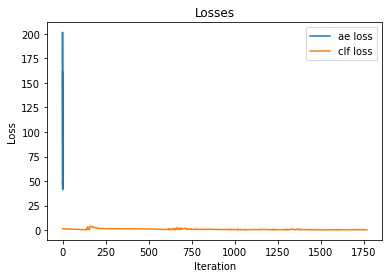

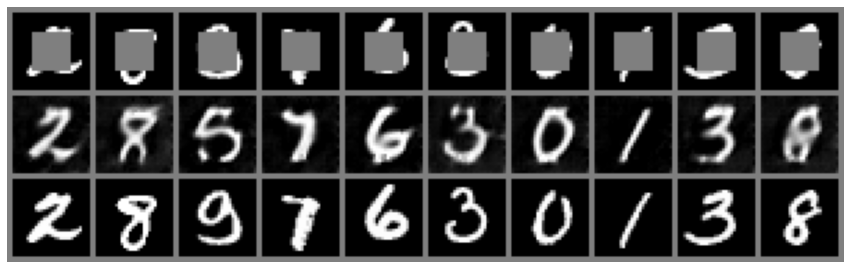

In [27]:
q1_results(q1)

# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




In [ ]:
from torchvision.transforms.functional import rotate

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class MyDataset(Dataset):
  def __init__(self, x, y):
    self.data = x.float() / 255 * 2 - 1
    self.target = y

  def __getitem__(self, idx):
      return self.data[idx], self.target[idx]

  def __len__(self):
    return len(self.data)

In [ ]:
class ImageRotations(nn.Module):
  def __init__(self, hd=128, n_rotations=4):
    assert 360 % n_rotations == 0
    super().__init__()
    self.classifier = Classifier(hd=hd, out_dim=n_rotations)
    self.n_rotations = n_rotations

  def fit(self, train_data, batch_size=512, lr=1e-3, n_epochs=10):
    imgs = [train_data.data]
    targets = [torch.zeros(len(imgs[0]), dtype=torch.long)]
    base_angle = 360 / self.n_rotations
    for _ in range(1, self.n_rotations):
      imgs.append(rotate(imgs[-1], base_angle))
      targets.append(targets[-1] + 1)
    dataset = MyDataset(torch.cat(imgs).unsqueeze(1), torch.cat(targets))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = Adam(self.classifier.parameters(), lr=lr)

    losses = []
    accs = []

    for epoch in trange(n_epochs, desc='Training'):
      acc = 0
      n_samples = 0
      for batch, label in dataloader:
        batch, label = batch.to(device), label.to(device)
        logit = self.classifier(batch)

        loss = F.cross_entropy(logit, label)
        pred = torch.argmax(logit, dim=-1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        acc += (label == pred).sum().item()
        n_samples += batch.size(0)
      accs.append(acc / n_samples)

    return np.array(losses), np.array(accs)

In [ ]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    Returns
    - a (# of training iterations, ) numpy array of full of losses
    - a (# of training epochs, ) numpy array of full of accuracy scores
    """
    model = ImageRotations()
    model.to(device)
    losses, accs = model.fit(train_data)
    return losses, accs

Training: 100%|██████████| 10/10 [05:20<00:00, 32.03s/it]


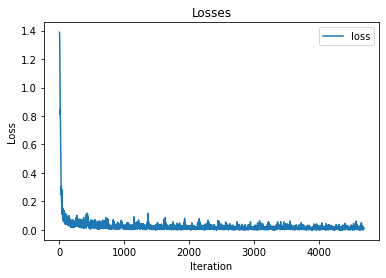

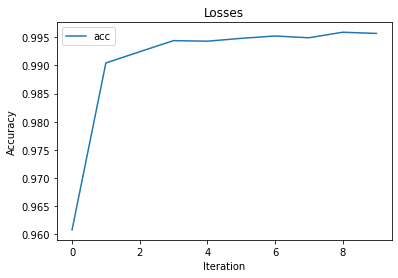

In [ ]:
q2_results(q2)